<a href="https://colab.research.google.com/github/potapov-dm/numbers_generation_cDCGAN/blob/main/cDCGAN_MNIST_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.initializers import RandomNormal

In [ ]:
def make_generator_model():
  noise = tf.keras.Input(shape=(NOISE_DIM,))
  label = tf.keras.Input(shape=(1,))

  label_embedding = layers.Embedding(NUM_OF_CLASSES, 100)(label)
  label_embedding = layers.Flatten()(label_embedding)

  input_concat = layers.Concatenate()([noise, label_embedding])

  dense = layers.Dense(7*7*128, use_bias=False)(input_concat)
  dense = layers.BatchNormalization()(dense)
  dense = layers.ReLU()(dense)

  reshaped = layers.Reshape((7, 7, 128))(dense)

  upsample1 = layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False)(reshaped)
  upsample1 = layers.BatchNormalization()(upsample1)
  upsample1 = layers.ReLU()(upsample1)

  upsample2 = layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False)(upsample1)
  upsample2 = layers.BatchNormalization()(upsample2)
  upsample2 = layers.ReLU()(upsample2)

  output = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(upsample2)

  model = tf.keras.Model(inputs=[noise, label], outputs=output)
  return model  #kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), LeakyRelu

# g = make_generator_model()
# display(tf.keras.utils.plot_model(g, show_shapes=True))

In [ ]:
def make_discriminator_model():
    image_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    label_input = layers.Input(shape=(1,))

    label_embedding = layers.Embedding(NUM_OF_CLASSES, 50)(label_input)
    label_embedding = layers.Dense(IMG_SIZE*IMG_SIZE)(label_embedding)
    label_embedding = layers.Reshape((IMG_SIZE, IMG_SIZE, 1))(label_embedding)

    input_concat = layers.Concatenate(axis=-1)([image_input, label_embedding])

    conv1 = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(input_concat)
    conv1 = layers.LeakyReLU()(conv1)
    conv1 = layers.Dropout(0.3)(conv1)

    conv2 = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.LeakyReLU()(conv2)
    conv2 = layers.Dropout(0.3)(conv2)

    flatten = layers.Flatten()(conv2)
    output = layers.Dense(1)(flatten)

    model = tf.keras.Model(inputs=[image_input, label_input], outputs=output)
    return model  #use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)

In [ ]:
def dataset_init(img_size):
  (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()

  def preprocess_image(image):
      image = tf.expand_dims(image, axis = 2)
      image = tf.image.resize(image, (img_size, img_size))
      image = (tf.cast(image, tf.float32) - 127.5) / 127.5
      return image

  def preprocess_label(label):
      return tf.cast(label, tf.int64)

  train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  train_dataset = train_dataset.map(lambda x, y: (preprocess_image(x), preprocess_label(y)))
  train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

  AUTOTUNE = tf.data.AUTOTUNE
  train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
  return train_dataset

In [ ]:
def show_result(noise, label):
  images = generator([noise, label], training=False)
  fig, axes = plt.subplots(NUM_OF_CLASSES, len(label) // NUM_OF_CLASSES, figsize=(5, 5))
  for i, ax in enumerate(axes.flat):
      ax.imshow(images[i], cmap='gray')
      ax.axis('off')
  plt.show()

In [ ]:
def show_train_hist(hist):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']
    plt.figure(figsize=(6, 3))

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()

    plt.show()


In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Train

In [ ]:
@tf.function
def train_step(image_batch, label_batch):
  noise_batch = tf.random.normal((len(label_batch), NOISE_DIM))

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_batch = generator([noise_batch, label_batch], training=True)

    real_output = discriminator([image_batch, label_batch], training=True)
    fake_output = discriminator([generated_batch, label_batch], training=True)

    disc_loss = discriminator_loss(real_output, fake_output)
    gen_loss = generator_loss(fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  # global losses_temp
  # losses_temp["gen"].append(gen_loss)
  # losses_temp["disc"].append(disc_loss)
  # print(losses_temp["gen"])

In [ ]:
def train(dataset, epochs):
  train_hist = {}
  train_hist['D_losses'] = []
  train_hist['G_losses'] = []
  train_hist['per_epoch_ptimes'] = []
  train_hist['total_ptime'] = []

  for epoch in range(epochs):
    start_time = time.time()
    global losses_temp
    losses_temp = {"disc": [], "gen": []}

    for image_batch, label_batch in train_dataset:
      train_step(image_batch, label_batch)

    # print('\n[%d/%d] - ptime: %.2f, d loss: %.2f, g loss: %.2f' % ((epoch + 1), epochs, time.time() - start_time, sum(losses_temp["disc"]) / len(losses_temp["disc"]), sum(losses_temp["gen"]) / len(losses_temp["gen"])))
    print('\n[%d/%d] - ptime: %.2f' % ((epoch + 1), epochs, time.time() - start_time))
    show_result(SEED, SEED_LABELS)

    # train_hist['D_losses'].append(sum(losses_temp["disc"]) / len(losses_temp["disc"]))
    # train_hist['G_losses'].append(sum(losses_temp["gen"]) / len(losses_temp["gen"]))
    # show_train_hist(train_hist)

In [ ]:
train_dataset = dataset_init(IMG_SIZE)
NUM_OF_CLASSES = 10
IMG_SIZE = 28

SEED = tf.random.normal((NUM_OF_CLASSES*10, NOISE_DIM))
SEED_LABELS = tf.repeat(tf.range(NUM_OF_CLASSES), 10)

In [ ]:
BATCH_SIZE = 128
LEARNING_RATE = 0.0002
EPOCHS = 20
BUFFER_SIZE = 60000
NOISE_DIM = 100


[1/20] - ptime: 15.32


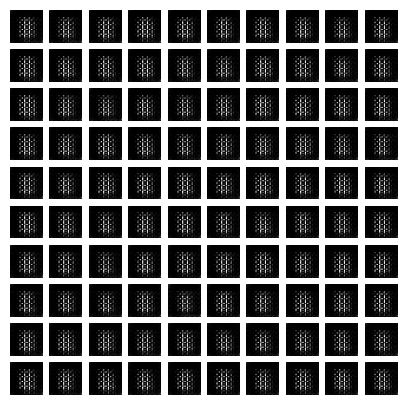


[2/20] - ptime: 9.25


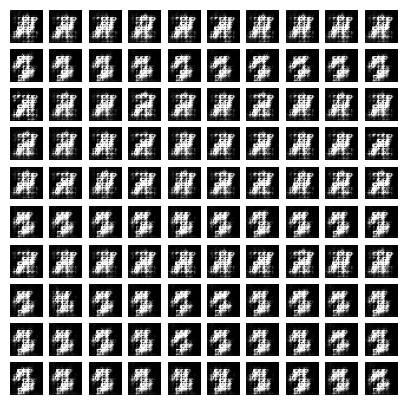


[3/20] - ptime: 9.11


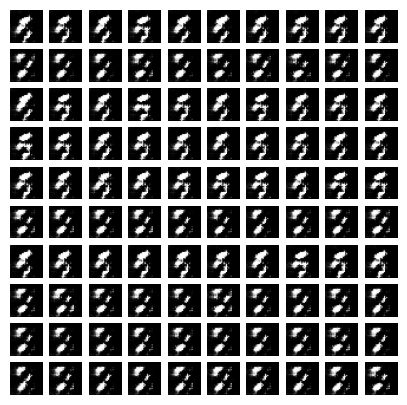


[4/20] - ptime: 9.01


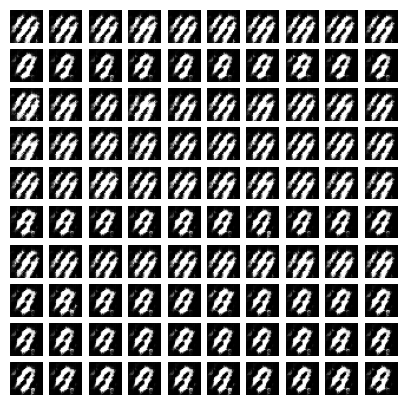


[5/20] - ptime: 9.01


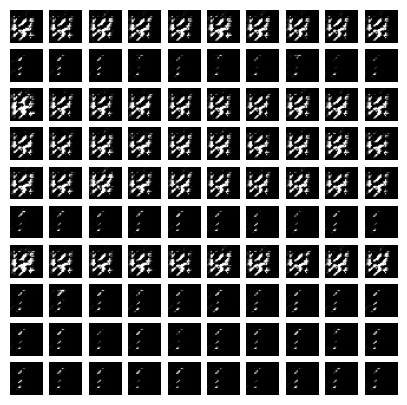


[6/20] - ptime: 8.98


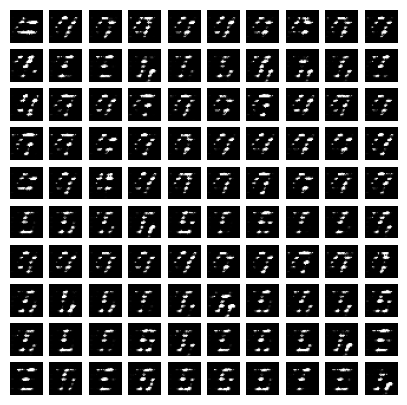


[7/20] - ptime: 8.93


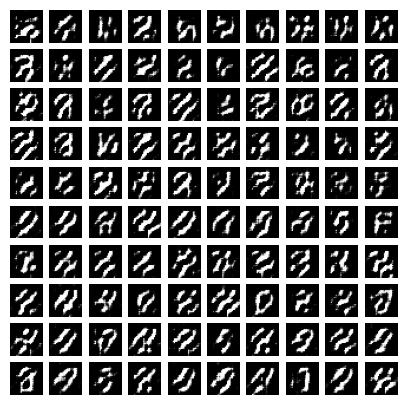


[8/20] - ptime: 8.93


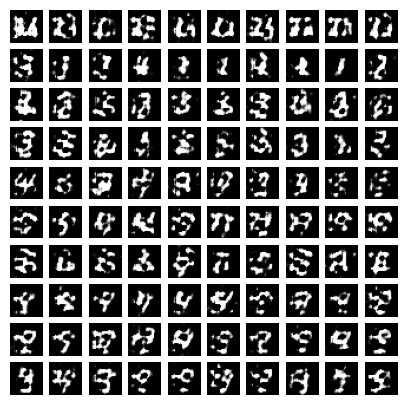


[9/20] - ptime: 8.97


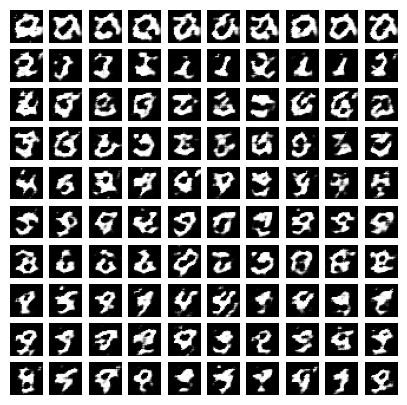


[10/20] - ptime: 8.96


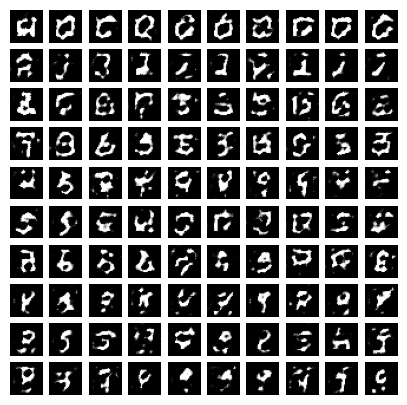


[11/20] - ptime: 8.98


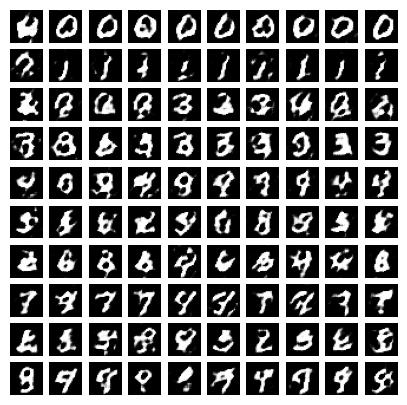


[12/20] - ptime: 8.99


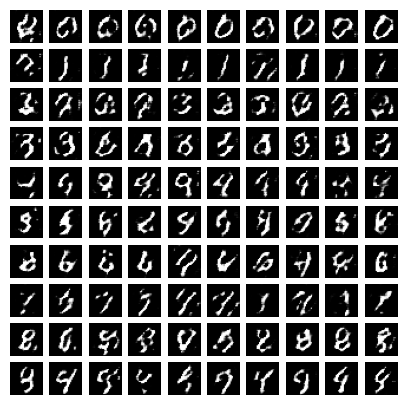


[13/20] - ptime: 8.96


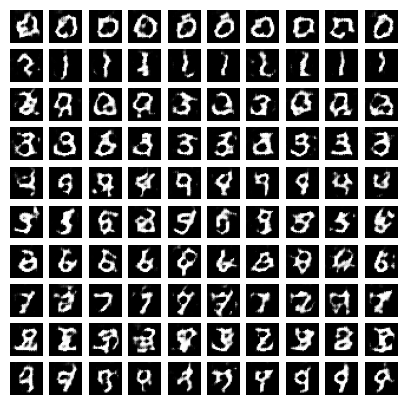


[14/20] - ptime: 8.99


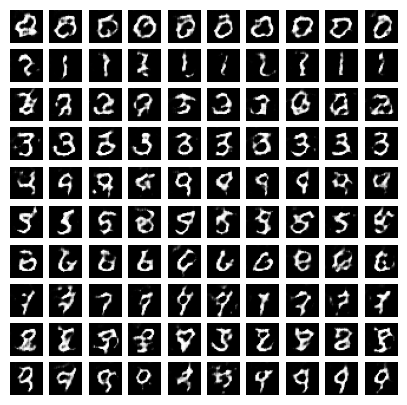


[15/20] - ptime: 8.96


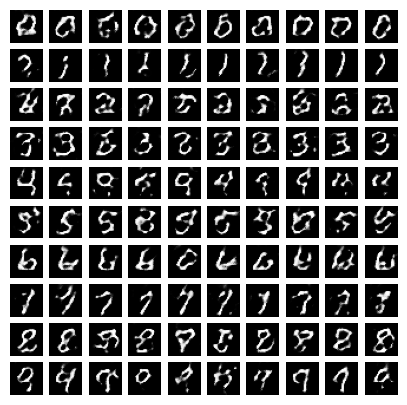


[16/20] - ptime: 9.02


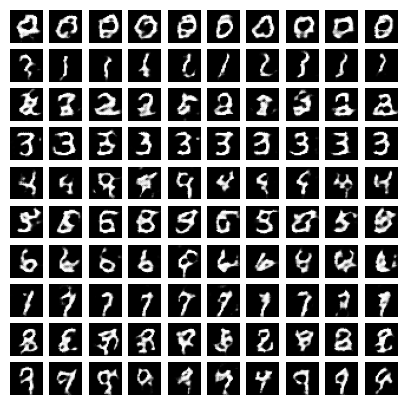


[17/20] - ptime: 9.00


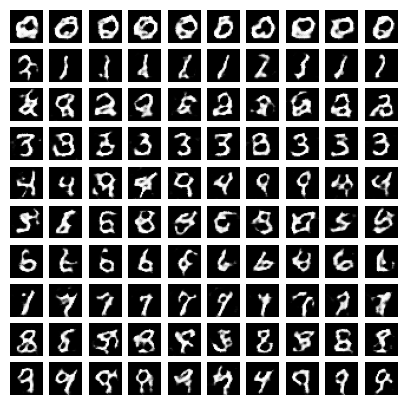


[18/20] - ptime: 9.00


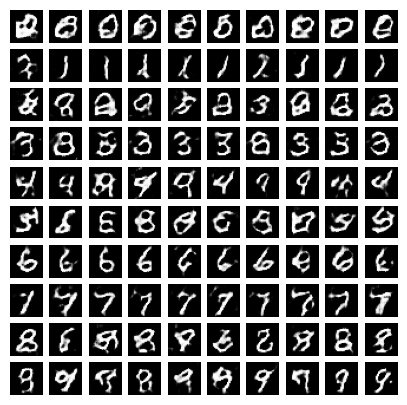


[19/20] - ptime: 9.05


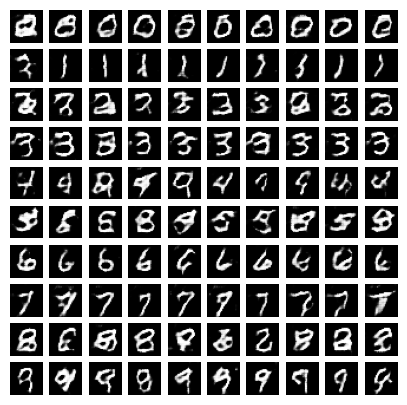


[20/20] - ptime: 9.02


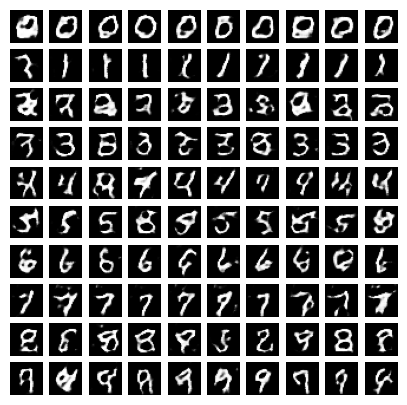

In [ ]:
generator = make_generator_model()
discriminator = make_discriminator_model()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
discriminator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE) #SGD

losses_temp = {"disc": [], "gen": []}

train(train_dataset, EPOCHS)